In [1]:
# Tensorflow'u ve kuantum kütüphanesi indirmemiz gerekiyor.
# (colab içindir, bilgisayarınızda kuruluysa bu kısmı silin)
!pip install -q tensorflow==2.3.1
!pip install -q tensorflow-quantum

# 1) Kütüphanelerin Eklenmesi

In [2]:
# Kullanılacak kütüphaneleri import edelim.
import tensorflow as tf
import tensorflow_quantum as tfq

from cirq.contrib.svg import SVGCircuit
import cirq

import sympy
import numpy as np

%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

# 2) Verisetinin Hazırlanması

In [3]:
# Notebook'ta keras içindeki hazır verisetlerinden olan MNIST veriseti kullanılacak.
# Önce verileri eğitim ve test olmak üzere ayıralım.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Verilerimizin olduğu listeye ekstra bir dimension ekledik.
# (ilgili link: https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it)
# Ve tüm pikselleri [0, 255] aralığından [0.0, 1.0] aralığına dönüştürülerek normalize ettik.
# (resmimiz gri skalada olduğu için piksel değerleri [0, 255] aralığındadır)
x_train = x_train[..., np.newaxis]/255.0
x_test = x_test[..., np.newaxis]/255.0

print("Verisetindeki eğitim resmi sayısı:", len(x_train))
print("Verisetindeki test resmi sayısı  :", len(x_test))

Verisetindeki eğitim resmi sayısı: 60000
Verisetindeki test resmi sayısı  : 10000


In [4]:
# Bu fonksiyon verisetindeki 10 sınıfı (0-9), sadece 3 ve 6 rakamı olacak şekilde 2 sınıfa indirger
def filtre_3_ve_6_sinifi(x, y):
    # Eğitim ve test verisetinin etiketleri için filtre uyguladık
    # `np.where` 3 ve 6 etiketlerinin bulunduğu indekslerin listesini döndürür.
    # Bu listeyi x ve y listelerine verdiğimizde 3 ve 6 etiketine sahip verileri elde ederiz.
    x = x[np.where((y == 3) | (y == 6))]
    y = y[np.where((y == 3) | (y == 6))]

    # Etiket listesine son bir işlem uygulayıp 3 olan değerleri True, 6 olanları False yaparız.
    # Yani sınıflandırma sonucunda True çıkarsa o resmin 6 olarak tahmin edildiği anlamına gelir.
    y = y == 3

    return x,y

In [5]:
# Sadece 3 ve 6 sınıfının bulunduğu yeni listemizi elde ederiz.
x_train, y_train = filtre_3_ve_6_sinifi(x_train, y_train)
x_test, y_test = filtre_3_ve_6_sinifi(x_test, y_test)

print("Filtrelenmiş eğitim resmi sayısı:", len(x_train))
print("Filtrelenmiş test resmi sayısı:", len(x_test))

Filtrelenmiş eğitim resmi sayısı: 12049
Filtrelenmiş test resmi sayısı: 1968


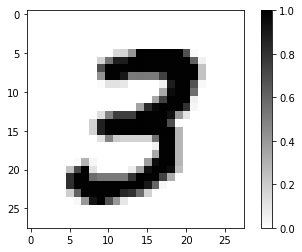

In [6]:
# Eğitim verisetimizdeki ilk resme göz atalım.
# Diğer resimlere bakmak için liste içerisindeki ilk sayıyı değiştirmemiz yeterli.
plt.imshow(x_train[0, :, :, 0], vmin=0, vmax=1, cmap=plt.get_cmap("binary"))
plt.colorbar()

In [7]:
# MNIST verisetindeki resimler 28x28 pikseldir.
# Kuantum programlamada kullanılacak kübit sayısındaki bazı sınırlardan dolayı,
# resimlerimizin boyutunu 3x3 piksele düşüreceğiz.
x_train_small = tf.image.resize(x_train, (4, 4))
x_test_small = tf.image.resize(x_test, (4, 4))

In [8]:
x_train_small.shape

TensorShape([12049, 4, 4, 1])

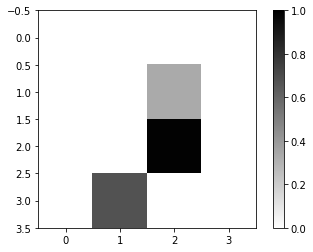

In [9]:
# Az önce baktığımız resmin 3x3 haline göz atalım.
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1, cmap=plt.get_cmap("binary"))
plt.colorbar()

In [10]:
# [0, 1] aralığına daralttığımız resimlerimizdeki pikseller 0.5 ten büyük ise 1,
# küçük ise 0 olarak yeniden etiketleriz. 255 aralığı olsaydı piksellerimizi
# 8 bit ile temsil etmemiz gerekirdi, ancak 0 ve 1 değerleri 1 bit ile ifade edilebilir.
# Yani her pikseli 1 kübit ile ifade edebiliriz.
THRESHOLD = 0.5

x_train_bin = np.array(x_train_small > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [11]:
# Az önce kullandığımız resmi ele alalaım ve resmimizdeki piksellerin değerlerini yazdıralım.
print('\n'.join('  '.join(str(x[0]) for x in row) for row in x_train_bin[0]))

0.0  0.0  0.0  0.0
0.0  0.0  0.0  0.0
0.0  0.0  1.0  0.0
0.0  1.0  0.0  0.0


# 3) Resimlerin Kuantum Devrelerine Kodlanması

In [12]:
# Resimlerimizi kuantum programlamada kullanabilmek için kübitler ile ifade etmeliyiz.
# Kübitler başlangıçta 0 değerindedirler. Her resmin piksel değerini tutabilmek için
# bu kübitleri devreden geçirmeliyiz. Dolayısıyla tüm resimler için birer devre oluştururuz.
# Bu fonksiyon parametre olarak verilen resmin kuantum devresine kodlar.
def _cz_and_swap(q0, q1, rot):
    yield cirq.CZ(q0, q1)**rot
    yield cirq.SWAP(q0,q1)

def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    
    # Bitleri 1 olanları kübitlere aktarmak için X kapılarını kullandıktan sonra,
    # fourrier uyguluyoruz.
    circuit.append(cirq.H(qubits[0]))

    for i in range(9-1):
      for j in range(9-1-i):
        circuit.append(_cz_and_swap(qubits[j], qubits[j+1], np.pi / (2**j)))
      circuit.append(cirq.H(qubits[0]))

    return circuit

In [13]:
# Elimizdeki tüm resimlerin kuantum devrelerini oluştururuz ve listede toplarız.
x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


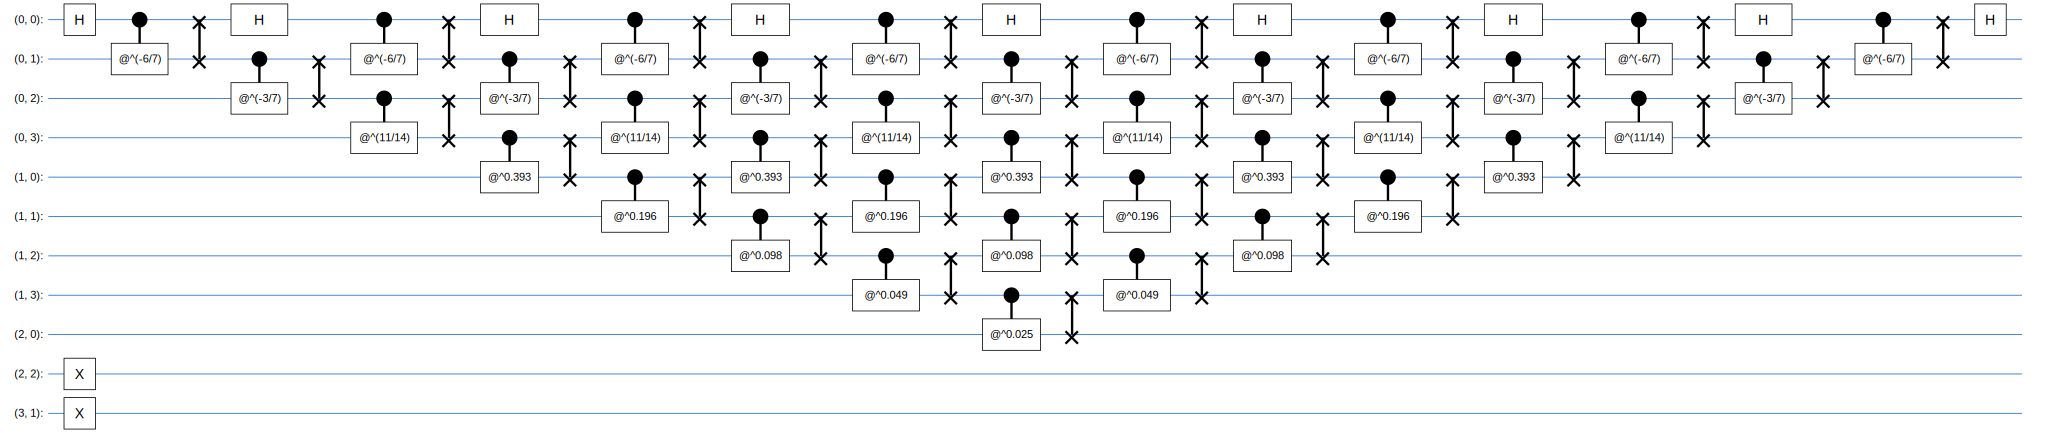

In [14]:
# Notebookta örnek olarak kullandığımız eğitim setindeki ilk resmin devresi şu şekildedir:
SVGCircuit(x_train_circ[0])

In [15]:
# Tüm devreleri bir tensöre çeviririz ve onları da listede saklarız.
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# 4) Kuantum Modelinin İnşa Edilmesi

In [16]:
# Bu sınıf, modelimizin katmanlarını türeteceğimiz sınıftır.
# Kübitleri ve readout parametreleri alır.
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [17]:
# Bu fonksiyon, kuantum modelini oluşturur.
# Modeldeki kübit sayısı veri devrelerindekiyle aynı olmalıdır.
# Ardından ekstra bir readout kübiti oluşturururuz. Bu kübit
# resmimiz için yaptığımız tahminin sonucunu tutacaktır.
def create_quantum_model():
    data_qubits = cirq.GridQubit.rect(4, 4)
    readout = cirq.GridQubit(-1, -1)
    circuit = cirq.Circuit()
    
    # readout kübitini hazırlıyoruz.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    # Devre katmanı oluşturucumuzdan bir nesne üretiyoruz,
    # ve nesnemize tüm kübitlerimizi tanımlıyoruz.
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Sonrasında katmanlarımızı ekliyoruz.
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # son olarak yine readout kübitini hazırlıyoruz.  
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [18]:
# Artık modeli oluşturalım.
model_circuit, model_readout = create_quantum_model()

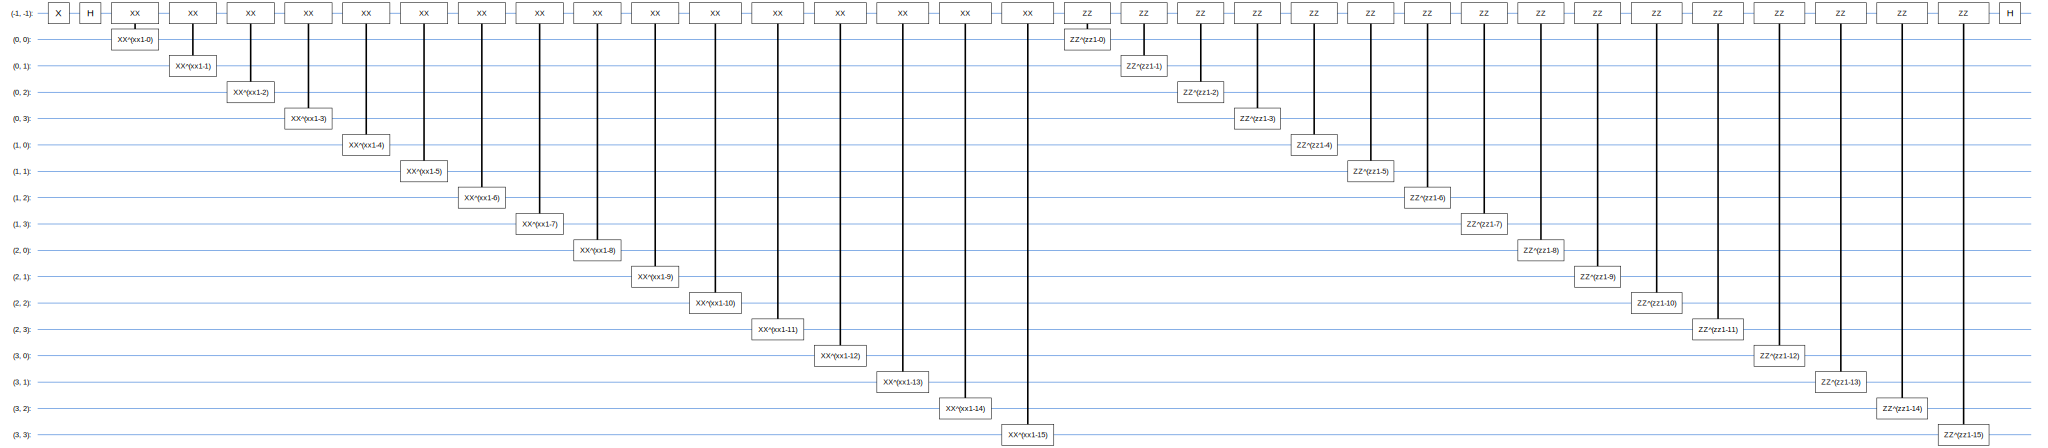

In [19]:
# Oluşturduğumuz modelde bir devre olarak temsil edilir.
# Model devremizi görselleştirelim.
SVGCircuit(model_circuit)

In [20]:
# Keras modelimizi oluşturalım.
model = tf.keras.Sequential([
    # Girdi resim devremizdir.
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # PQC katmanı readout kapısının beklenen değerini [-1,1] aralığında döndürür.
    tfq.layers.PQC(model_circuit, model_readout),
])

In [21]:
# Hinge accurasy kullanacağımız için etiketlerimizi -1 ve 1 aralığına çevirelim.
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [22]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

# 5) Modelin Derlenmesi

In [23]:
# modelimizi kayıp fonksiyonu olarak Hinge ve optimizer olarak Adam algortimasını seçerek derleyelim.
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [24]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


# 6) Modelin Eğitilmesi

In [25]:
# Modelimizi eğitirken kullanacağımız parametreleri belirleyelim.

EPOCHS = 3
BATCH_SIZE = 32

# Modele resimleri dönüştürdüğümüz devrelerin tensör hallerini vereceğiz.
# Bundan dolayı tüm verisetini kullanmak için onun uzunluğunu alacağız. 
NUM_EXAMPLES = len(x_train_tfcirc) 

In [26]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [27]:
# Model eğitiminin ne kadar süreceğini ölçmek için eğitimden önce zamanı kaydedelim.
import time
start_time = time.time()

In [28]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
377/377 [==============================] - 1077s 3s/step - loss: 0.8824 - hinge_accuracy: 0.6908 - val_loss: 0.7696 - val_hinge_accuracy: 0.7969
Epoch 2/3
377/377 [==============================] - 1082s 3s/step - loss: 0.5070 - hinge_accuracy: 0.8242 - val_loss: 0.3409 - val_hinge_accuracy: 0.8281
Epoch 3/3
62/62 [==============================] - 31s 500ms/step - loss: 0.3392 - hinge_accuracy: 0.8281


In [29]:
# Başlangıçtaki zamana bakarak eğitimin kaç saniye sürdüğünü yazdıralım.
print(f"Model eğitimi {time.time() - start_time} saniye sürdü.")

Model eğitimi 3277.909492254257 saniye sürdü.


In [30]:
# Modelimizin doğruluğuna baktığımızda 0.84 civarı olduğunu görebiliriz.
qnn_accuracy = qnn_results[1]
qnn_accuracy

0.828125

# 7) Değerlendirme

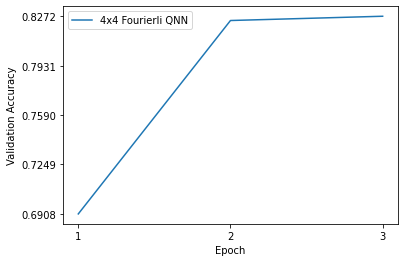

In [31]:
plt.plot(qnn_history.history['hinge_accuracy'], label='4x4 Fourierli QNN')
plt.xticks([0, 1, 2], [1,2,3])
plt.yticks(np.linspace(qnn_history.history['hinge_accuracy'][0], qnn_history.history['hinge_accuracy'][-1], 5))
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

11465
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


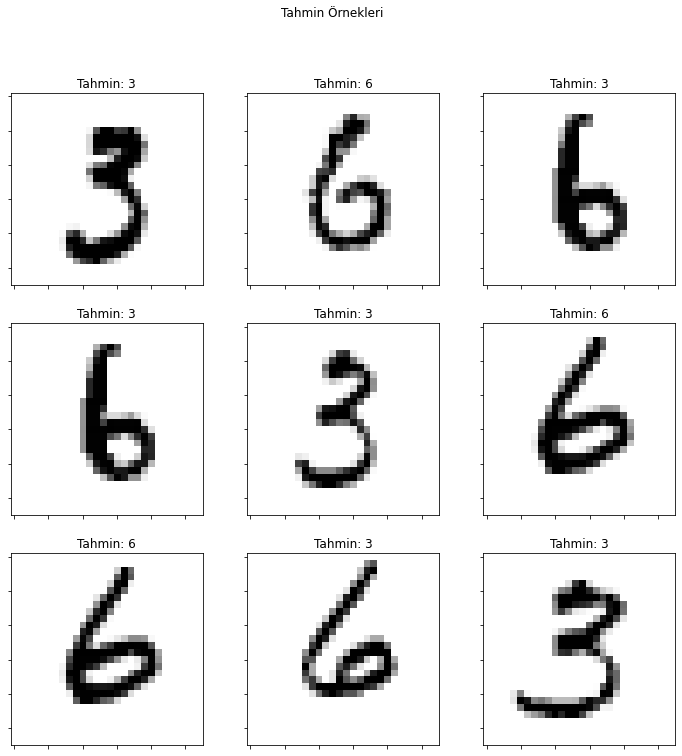

In [32]:
import random

ilk_indeks = random.randint(0, NUM_EXAMPLES-10)
print(ilk_indeks)

fig = plt.figure(figsize=(12, 12))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

for i in range(3):
  for j in range(3):
    ax = fig.add_subplot(gs[i, j])
    ax.title.set_text("Tahmin: " + ("3" if model.predict_classes(x_train_tfcirc[(2*i+j+ilk_indeks):(2*i+j+ilk_indeks+1)])[0][0] == 1 else "6"))
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.imshow(x_train[2*i+j+ilk_indeks, :, :, 0], cmap=plt.get_cmap("binary"))

fig.suptitle("Tahmin Örnekleri")

plt.show()